In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", context="notebook")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression


In [5]:
RANDOM_STATE = 42

# ===== 1) Load =====
CSV_PATH = "/kaggle/input/credit-scoring-synthetic-data/synthetic_e2dabba50a1a4fbcabd601f7883eef1e(in).csv"  # change if needed
df = pd.read_csv(CSV_PATH)


In [6]:
# ===== 2) Detect target & basic cleaning =====
target_candidates = [c for c in df.columns if c.lower() == "default"]
if not target_candidates:
    raise ValueError(f"No 'DEFAULT' column found. Columns: {list(df.columns)}")
TARGET = target_candidates[0]

id_cols = [c for c in df.columns if c.upper() in {"CUST_ID", "ID", "CUSTOMER_ID"}]
X = df.drop(columns=[TARGET] + id_cols)
y = df[TARGET].astype(int)

print(f"Target: {TARGET}")
if id_cols:
    print("Dropped ID columns:", id_cols)
print("Shape:", df.shape)
print("Class balance:\n", y.value_counts(normalize=True).rename("proportion"))

Target: DEFAULT
Dropped ID columns: ['CUST_ID']
Shape: (4995, 87)
Class balance:
 DEFAULT
0    0.709109
1    0.290891
Name: proportion, dtype: float64


In [8]:
df.describe()

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,...,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
count,4995.000000,4.995000e+03,4.995000e+03,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,...,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000
mean,112030.816016,4.184128e+05,7.200020e+05,4.489922,6.176271,6.731365,7336.379580,3252.797998,0.453754,0.056720,...,0.933820,0.716500,0.651286,0.945345,0.220220,0.180981,0.994194,0.174575,587.779980,0.290891
std,121991.815056,4.384830e+05,9.975662e+05,4.382761,4.924046,14.994629,7483.619666,5182.946091,0.242308,0.038266,...,0.169589,1.220073,1.385736,0.227328,0.414437,0.385041,0.075982,0.379641,62.274917,0.454219
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.083300,0.006800,0.000000,0.000000,0.000000,0.003400,...,0.666700,0.067600,0.033800,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,0.000000
25%,8950.500000,7.575250e+04,1.998050e+04,0.980800,2.246250,0.684450,1314.000000,61.000000,0.257050,0.028550,...,0.807250,0.161150,0.101200,1.000000,0.000000,0.000000,1.000000,0.000000,551.000000,0.000000
50%,61229.000000,2.891120e+05,2.271580e+05,2.977400,5.125400,2.368600,5185.000000,1008.000000,0.438900,0.047500,...,0.922100,0.333400,0.238000,1.000000,0.000000,0.000000,1.000000,0.000000,595.000000,0.000000
75%,191468.000000,6.234835e+05,1.095794e+06,6.799900,8.986100,6.259600,11095.000000,4196.000000,0.639750,0.075000,...,1.028200,0.719300,0.658050,1.000000,0.000000,0.000000,1.000000,0.000000,634.000000,1.000000
max,662094.000000,2.911863e+06,5.968620e+06,16.111200,33.235100,251.571000,43255.000000,39918.000000,1.058300,0.251700,...,1.662800,10.001900,10.005300,1.000000,1.000000,1.000000,1.000000,1.000000,773.000000,1.000000


In [9]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum().sort_values(ascending=False).head(10))
print("\nTarget Balance:\n", df["DEFAULT"].value_counts(normalize=True))

Dataset Shape: (4995, 87)

Columns: ['CUST_ID', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6', 'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS', 'R_CLOTHING_DEBT', 'T_EDUCATION_12', 'T_EDUCATION_6', 'R_EDUCATION', 'R_EDUCATION_INCOME', 'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT', 'T_ENTERTAINMENT_12', 'T_ENTERTAINMENT_6', 'R_ENTERTAINMENT', 'R_ENTERTAINMENT_INCOME', 'R_ENTERTAINMENT_SAVINGS', 'R_ENTERTAINMENT_DEBT', 'T_FINES_12', 'T_FINES_6', 'R_FINES', 'R_FINES_INCOME', 'R_FINES_SAVINGS', 'R_FINES_DEBT', 'T_GAMBLING_12', 'T_GAMBLING_6', 'R_GAMBLING', 'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS', 'R_GAMBLING_DEBT', 'T_GROCERIES_12', 'T_GROCERIES_6', 'R_GROCERIES', 'R_GROCERIES_INCOME', 'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT', 'T_HEALTH_12', 'T_HEALTH_6', 'R_HEALTH', 'R_HEALTH_INCOME', 'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT', 'T_HOUSING_12', 'T_HOUSING_6', 'R_HOUSING', 'R_HOUSING_INCOME', 'R_HOUSING_SAVINGS', 'R_HOUSI

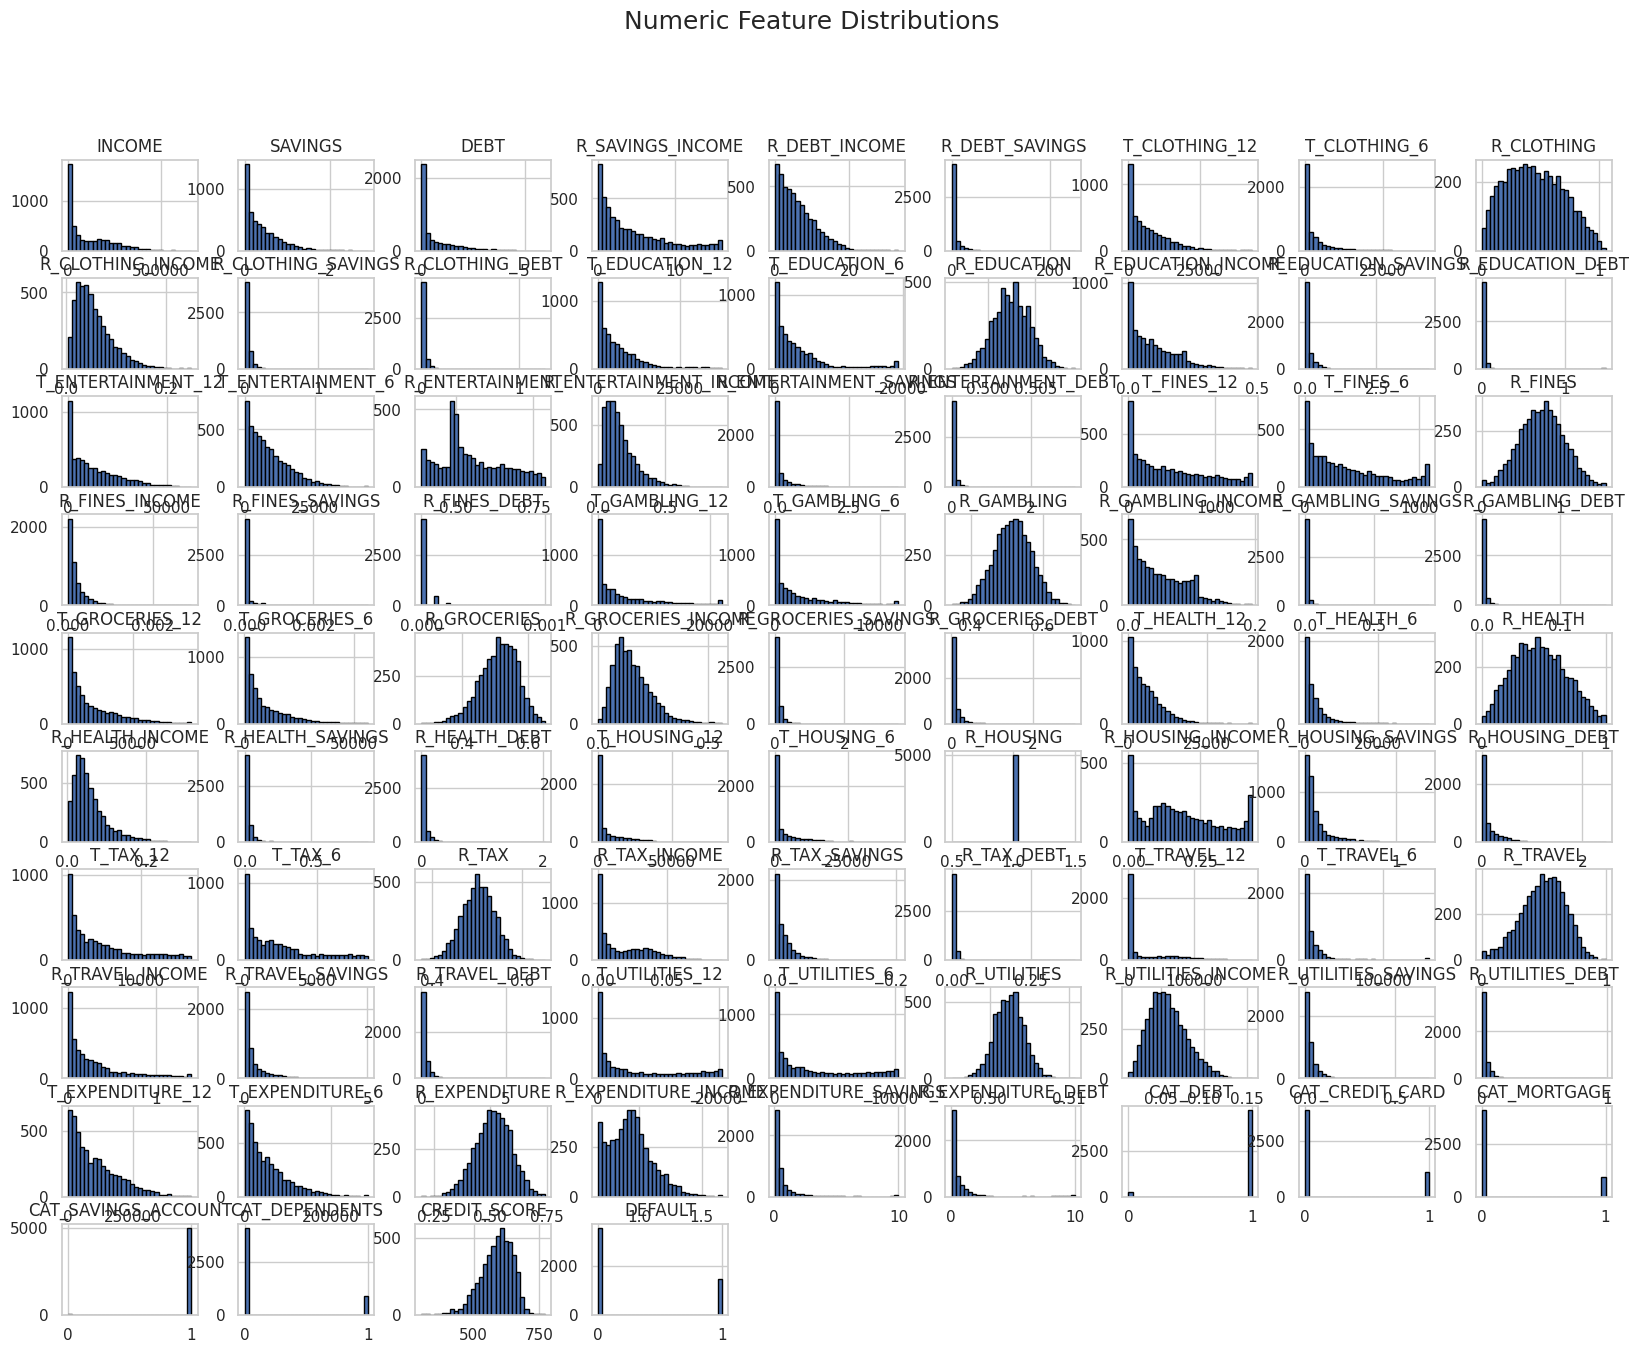

In [10]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

df[numeric_cols].hist(figsize=(20, 15), bins=30, edgecolor="black")
plt.suptitle("Numeric Feature Distributions", fontsize=18)
plt.show()

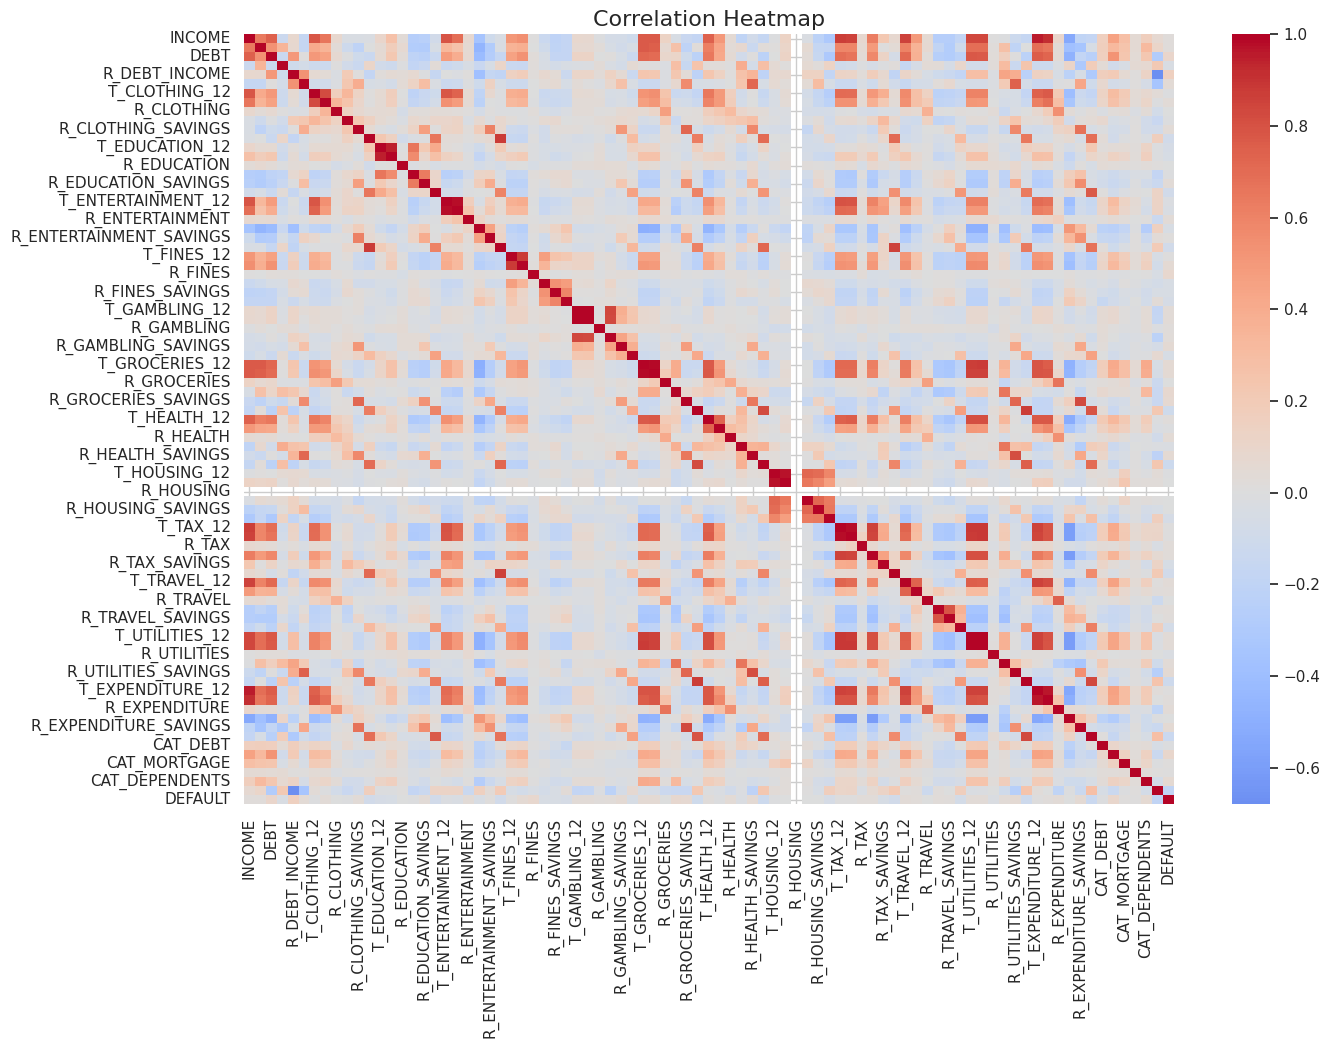

In [11]:
plt.figure(figsize=(15, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

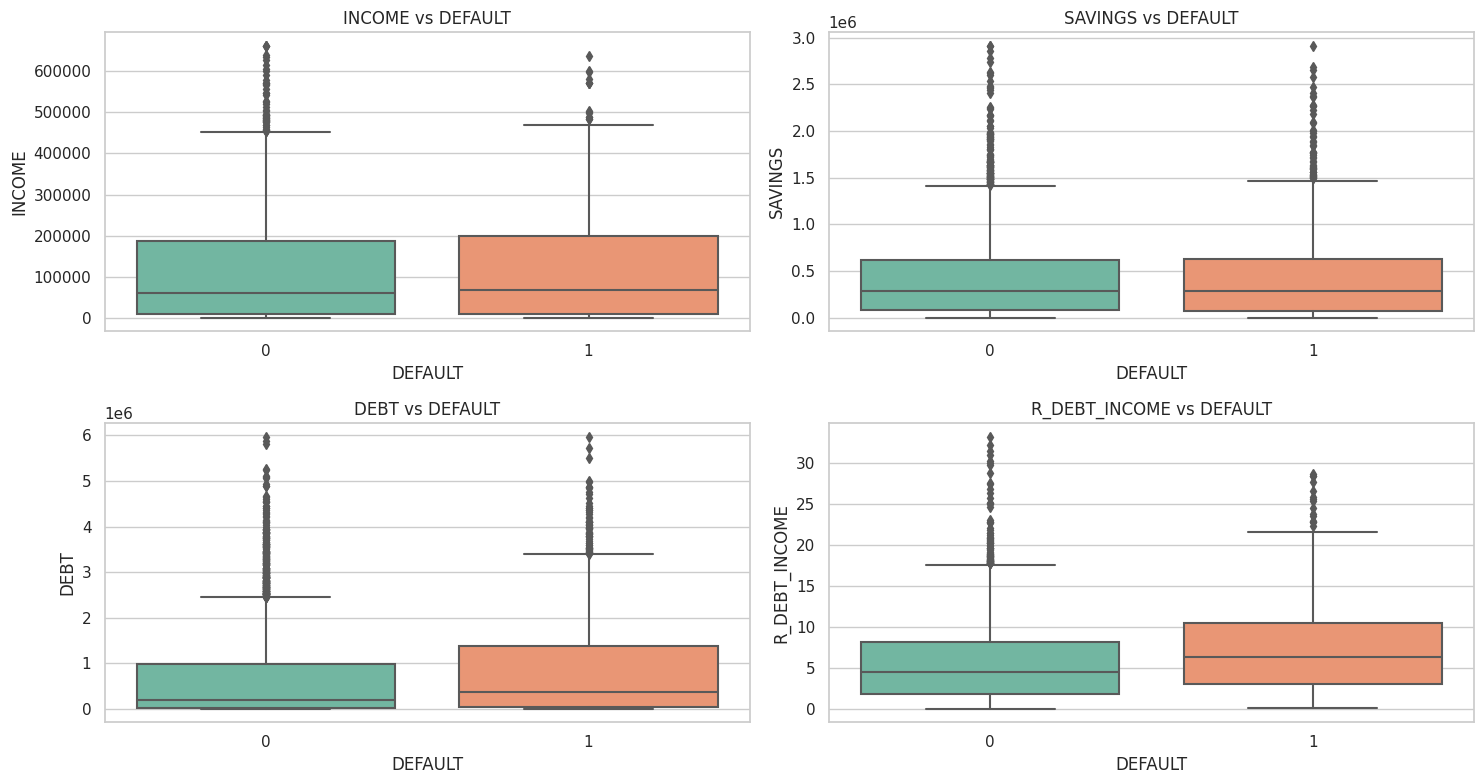

In [14]:
# Target vs. Numeric Features (Boxplots)
# ================================
sample_features = ["INCOME", "SAVINGS", "DEBT", "R_DEBT_INCOME"]
plt.figure(figsize=(15, 8))
for i, col in enumerate(sample_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="DEFAULT", y=col, data=df, palette="Set2")
    plt.title(f"{col} vs DEFAULT")
plt.tight_layout()
plt.show()

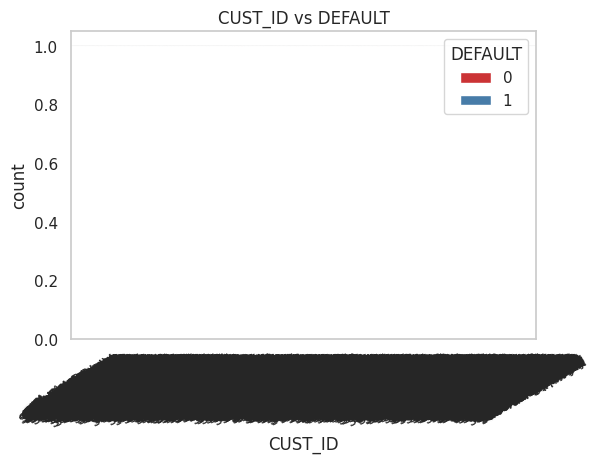

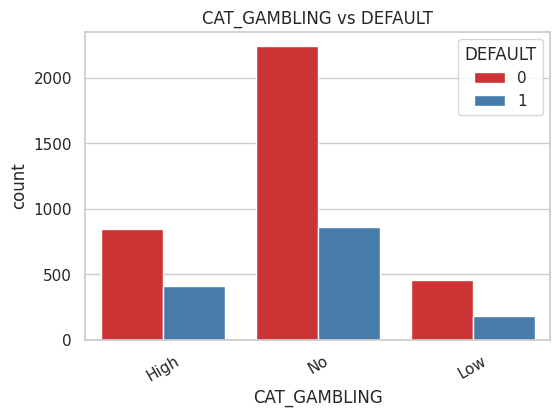

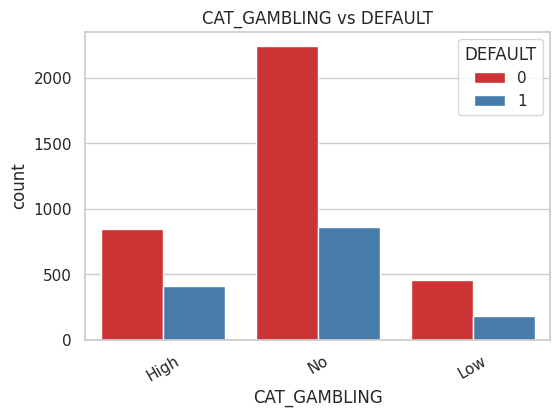

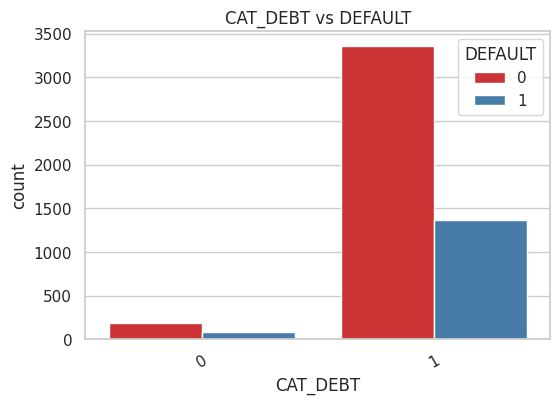

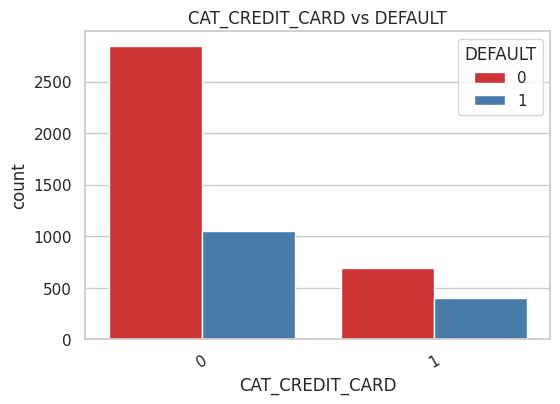

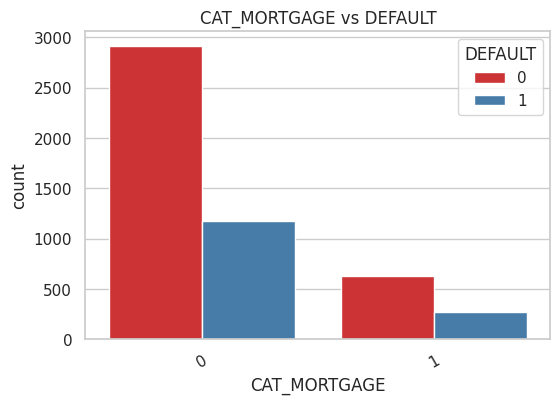

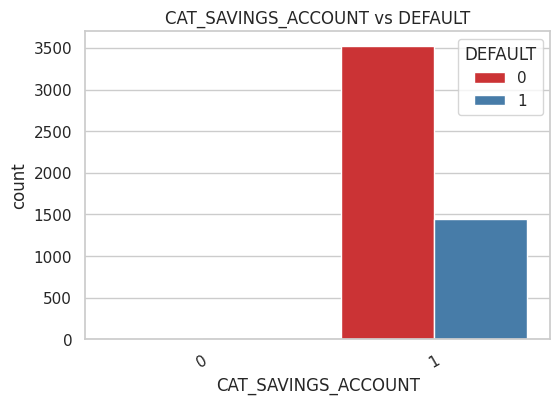

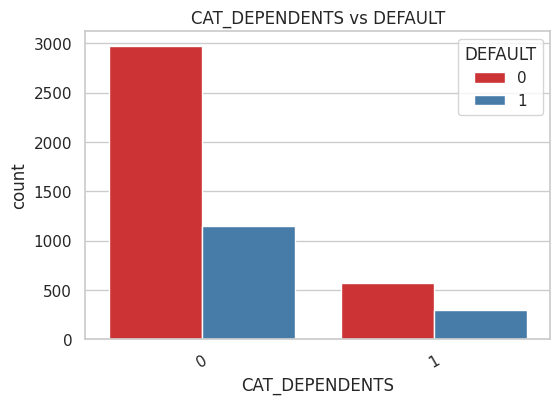

In [15]:
# 5. Categorical Variables vs Target
# ================================
cat_cols = df.select_dtypes(include=["object"]).columns.tolist() + \
           [c for c in df.columns if "CAT_" in c]

for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, hue="DEFAULT", data=df, palette="Set1")
        plt.title(f"{col} vs DEFAULT")
        plt.xticks(rotation=30)
        plt.show()


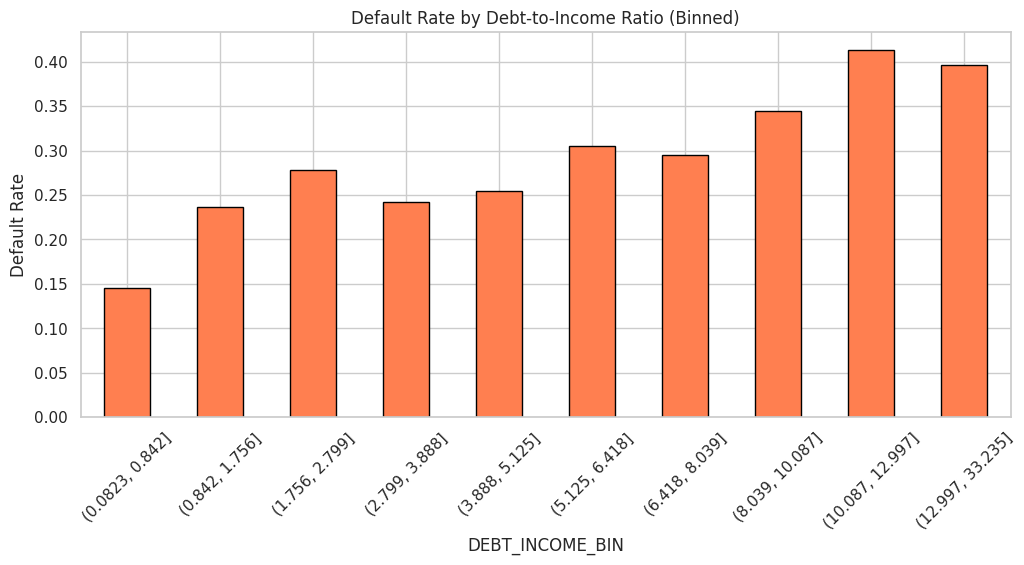

In [16]:
# 6. Default Rate by Debt-to-Income Ratio (Binned)
# ================================
df["DEBT_INCOME_BIN"] = pd.qcut(df["R_DEBT_INCOME"], q=10, duplicates="drop")
default_rate = df.groupby("DEBT_INCOME_BIN")["DEFAULT"].mean()

plt.figure(figsize=(12,5))
default_rate.plot(kind="bar", color="coral", edgecolor="black")
plt.title("Default Rate by Debt-to-Income Ratio (Binned)")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()

In [17]:
# ===== 3) Train/Test split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)


In [18]:
# ===== 4) Column types & Preprocessor =====
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

In [20]:
 #===== 5) Logistic Regression model =====
# saga supports l1/l2/elasticnet & large sparse OHE matrices; class_weight helps imbalance
logreg = LogisticRegression(
    penalty="l2",
    solver="saga",
    max_iter=5000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline([("preprocess", pre), ("model", logreg)])


In [21]:
# ===== 6) Cross-validation on training data =====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"roc_auc": "roc_auc", "f1": "f1", "precision": "precision", "recall": "recall", "accuracy": "accuracy"}
cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
print("\n=== 5-Fold CV (Training) — Logistic Regression ===")
for k in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    print(f"{k:>9}: {cv_res['test_'+k].mean():.4f} ± {cv_res['test_'+k].std():.4f}")


=== 5-Fold CV (Training) — Logistic Regression ===
  roc_auc: 0.6510 ± 0.0163
       f1: 0.4696 ± 0.0148
precision: 0.3871 ± 0.0115
   recall: 0.5973 ± 0.0250
 accuracy: 0.6079 ± 0.0109


In [22]:
# ===== 7) Fit on full training & evaluate on test =====
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

In [24]:
print("\n=== Test Metrics — Logistic Regression ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print(f"PR-AUC   : {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


=== Test Metrics — Logistic Regression ===
Accuracy : 0.6527
Precision: 0.4369
Recall   : 0.6667
F1       : 0.5279
ROC-AUC  : 0.7071
PR-AUC   : 0.4588

Classification Report:
               precision    recall  f1-score   support

           0     0.8252    0.6469    0.7253       708
           1     0.4369    0.6667    0.5279       291

    accuracy                         0.6527       999
   macro avg     0.6311    0.6568    0.6266       999
weighted avg     0.7121    0.6527    0.6678       999



<Figure size 500x400 with 0 Axes>

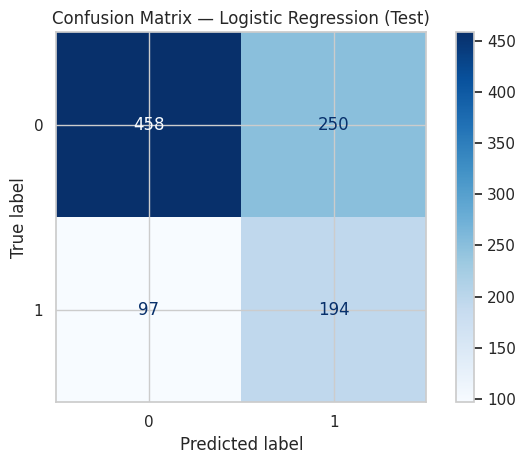

In [25]:

# ===== 8) Confusion matrix =====
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Logistic Regression (Test)")
plt.tight_layout()
plt.show()

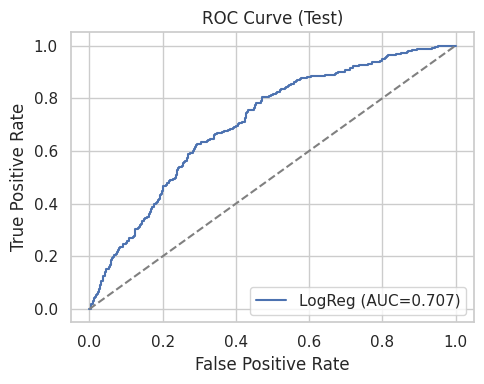

In [27]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc:.3f})")
plt.plot([0,1],[0,1], "--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()




In [28]:
# ===== 10) Top predictors (coefficients) =====
# Map coefficients back to feature names
# Get names from ColumnTransformer
ohe = pipe.named_steps["preprocess"].named_transformers_["cat"]
ohe_features = []
if cat_cols:
    ohe_features = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + ohe_features

coef = pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

print("\nTop positive predictors (increase default odds):")
print(coef_df.head(10)[["feature","coef"]])

print("\nTop negative predictors (decrease default odds):")
print(coef_df.tail(10).sort_values("abs_coef", ascending=False)[["feature","coef"]])



Top positive predictors (increase default odds):
             feature      coef
72  T_EXPENDITURE_12 -1.264109
59        R_TAX_DEBT -0.955426
36    T_GROCERIES_12  0.841533
17  R_EDUCATION_DEBT -0.805006
73   T_EXPENDITURE_6  0.748622
37     T_GROCERIES_6 -0.724942
0             INCOME  0.535608
31      T_GAMBLING_6  0.525585
30     T_GAMBLING_12 -0.432131
55           T_TAX_6  0.430394

Top negative predictors (decrease default odds):
                 feature      coef
75  R_EXPENDITURE_INCOME -0.015239
14           R_EDUCATION -0.014102
67         T_UTILITIES_6  0.014076
56                 R_TAX  0.012986
15    R_EDUCATION_INCOME -0.008205
64      R_TRAVEL_SAVINGS  0.007980
81   CAT_SAVINGS_ACCOUNT -0.006374
80          CAT_MORTGAGE  0.004044
60           T_TRAVEL_12  0.003046
50             R_HOUSING  0.000000
